# 4a. Organise predictions for a production pipeline

In the previous notebooks in this series, we worked with raw probability distributions — PMF arrays from group snapshots (3a, 3b) and Poisson-based distributions from yet-to-arrive models (3e). We used functions like `get_prob_dist_for_prediction_moment()` and `ParametricIncomingAdmissionPredictor.predict()` to generate these distributions, and `plot_prob_dist()` to visualise them.

These building blocks work well for individual predictions, but a production system needs to combine multiple demand sources (current patients, yet-to-arrive patients), for multiple services (medical, surgical, paediatric, ...), at multiple times of day. How do we organise all of these predictions in a structured way?

This notebook introduces the data classes that `patientflow` uses to organise prediction inputs and outputs for a production pipeline:

1. **`FlowInputs`** — a named container for a single source of patient flow (a PMF array or a Poisson rate)
2. **`ServicePredictionInputs`** — a grouping of all inflows and outflows for one service
3. **`DemandPredictor`** — the prediction engine that convolves flows into a combined distribution
4. **`FlowSelection`** — a toggle for which flows to include in a prediction
5. **`PredictionBundle`** — the output: arrivals, departures, and net flow bundled together

The 4x_ notebooks use these classes extensively. By understanding them here, you will be well prepared for the full UCLH implementation that follows.

This notebook generates fake data on-the-fly, so you can run it immediately without any external data.

In [22]:
# Reload functions every time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate fake data and train simple models

We reuse the fake data generation from notebooks 3a and 3c. First, fake ED snapshots for training an admission probability model:

In [23]:
from datetime import date, timedelta
from patientflow.generate import create_fake_snapshots, create_fake_finished_visits
from patientflow.prepare import create_temporal_splits
from patientflow.train.classifiers import train_classifier

prediction_times = [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]

snapshots_df = create_fake_snapshots(
    prediction_times=prediction_times,
    start_date='2023-01-01',
    end_date='2023-04-01',
    mean_patients_per_day=100
)

# Temporal splits
start_training_set = date(2023, 1, 1)
start_validation_set = date(2023, 2, 15)
start_test_set = date(2023, 3, 1)
end_test_set = date(2023, 4, 1)

train_visits, valid_visits, test_visits = create_temporal_splits(
    snapshots_df, start_training_set, start_validation_set,
    start_test_set, end_test_set,
    col_name='snapshot_date', patient_id='patient_id', visit_col='visit_number'
)

# Train a simple admission probability model (as in notebook 3a)
model = train_classifier(
    train_visits, valid_visits, test_visits=test_visits,
    grid={'n_estimators': [30]},
    prediction_time=(12, 0),
    exclude_from_training_data=['visit_number', 'snapshot_date', 'prediction_time'],
    ordinal_mappings={'latest_triage_score': [1, 2, 3, 4, 5]},
    visit_col='visit_number',
    use_balanced_training=True,
    calibrate_probabilities=True
)


Patient Set Overlaps (before random assignment):
Train-Valid: 0 of 5318
Valid-Test: 102 of 3690
Train-Test: 307 of 6129
All Sets: 0 of 7364 total patients
Split sizes: [6406, 2122, 4304]


Next, fake arrival data for training a yet-to-arrive model (as in notebook 3e):

In [24]:
import pandas as pd
from patientflow.predictors.incoming_admission_predictors import ParametricIncomingAdmissionPredictor

visits_df, _, _ = create_fake_finished_visits(
    '2023-01-01', '2023-04-01', mean_patients_per_day=50, admitted_only=True
)
inpatient_arrivals = visits_df.rename(
    columns={'departure_datetime': 'admitted_to_ward_datetime'}
).drop(columns='is_admitted')
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'])

train_arrivals, _, _ = create_temporal_splits(
    inpatient_arrivals, start_training_set, start_validation_set,
    start_test_set, end_test_set, col_name='arrival_datetime'
)

# Train a parametric yet-to-arrive model (as in notebook 3e)
train_arrivals_copy = train_arrivals.copy(deep=True)
if 'arrival_datetime' in train_arrivals_copy.columns:
    train_arrivals_copy.set_index('arrival_datetime', inplace=True)

num_days = (start_validation_set - start_training_set).days

yta_model = ParametricIncomingAdmissionPredictor(verbose=False)
yta_model.fit(
    train_arrivals_copy,
    prediction_window=timedelta(hours=8),
    yta_time_interval=timedelta(minutes=15),
    prediction_times=prediction_times,
    num_days=num_days
)

Split sizes: [2214, 710, 1584]


ParametricIncomingAdmissionPredictor(filters={})

We also need the aspirational curve parameters for the parametric model. These are loaded from the config file in the repository:

In [25]:
from patientflow.load import load_config_file, set_file_paths, set_project_root

project_root = set_project_root()
_, _, _, config_path = set_file_paths(project_root, data_folder_name='data-public', verbose=False)
params = load_config_file(config_path)
x1, y1, x2, y2 = params['x1'], params['y1'], params['x2'], params['y2']

print(f'Aspirational targets: {y1*100:.0f}% admitted within {x1:.0f} hours, '
      f'{y2*100:.0f}% within {x2:.0f} hours')

Inferred project root: /Users/zellaking/Repos/patientflow
Aspirational targets: 80% admitted within 4 hours, 99% within 12 hours


## Step 1: Start with a familiar result — a raw PMF array

In notebook 3a we used `get_prob_dist_for_prediction_moment()` to predict a bed count distribution for a group of patients. The result was a raw PMF array — an array where each element gives the probability of needing that many beds.

Let's reproduce this here, selecting one group snapshot from the fake data and passing it through the trained model.

In [26]:
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict
from patientflow.aggregate import get_prob_dist_for_prediction_moment

# Select a single group snapshot — all patients at 12:00 on a particular date
prediction_time = (12, 0)
group_snapshots_dict = prepare_group_snapshot_dict(
    snapshots_df[snapshots_df.prediction_time == prediction_time]
)
snapshot_date = list(group_snapshots_dict.keys())[0]
snapshot_ids = group_snapshots_dict[snapshot_date]

# Prepare for the model
X_test, y_test = prepare_patient_snapshots(
    df=snapshots_df.loc[snapshot_ids],
    prediction_time=prediction_time,
    single_snapshot_per_visit=False,
    label_col='is_admitted'
)

# Generate the probability distribution — the same approach as in notebook 3a
bed_count_prob_dist = get_prob_dist_for_prediction_moment(
    X_test, model, inference_time=True
)

# The result is a raw PMF: probabilities indexed by bed count
pmf_array = bed_count_prob_dist['agg_predicted']['agg_proba'].values
print(f'Snapshot: {len(snapshot_ids)} patients in the ED at 12:00 on {snapshot_date}')
print(f'PMF array shape: {pmf_array.shape}')
print(f'Sum of probabilities: {pmf_array.sum():.4f}')

Snapshot: 21 patients in the ED at 12:00 on 2023-01-01
PMF array shape: (22,)
Sum of probabilities: 1.0000


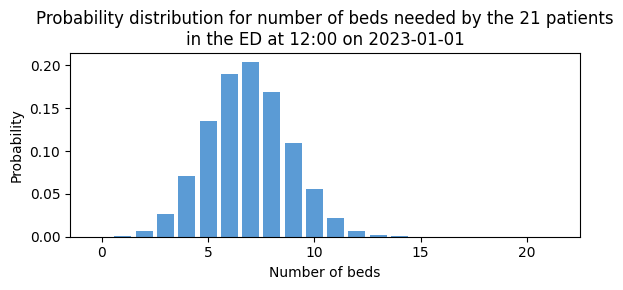

In [27]:
import numpy as np
from patientflow.viz.probability_distribution import plot_prob_dist
from patientflow.viz.utils import format_prediction_time

title = (
    f'Probability distribution for number of beds needed by the '
    f'{len(snapshot_ids)} patients\n'
    f'in the ED at {format_prediction_time(prediction_time)} '
    f'on {snapshot_date}'
)
plot_prob_dist(pmf_array, title, include_titles=True)

This is exactly the kind of result we produced in the 3x_ notebooks — a numpy array of probabilities. Now let's see how `patientflow` wraps this in a named container.

## Step 2: Wrap the PMF in a `FlowInputs` container

A `FlowInputs` object is a lightweight, immutable container that holds a single source of patient flow. It adds three pieces of metadata to the raw distribution:

- **`flow_id`** — a unique identifier (e.g. `"ed_current"`)
- **`flow_type`** — either `"pmf"` or `"poisson"`, so downstream code knows how to handle it
- **`display_name`** — an optional human-readable label

The distribution itself is stored in the `distribution` attribute — exactly the same numpy array we just plotted.

In [28]:
from patientflow.predict.service import FlowInputs

ed_current_flow = FlowInputs(
    flow_id="ed_current",
    flow_type="pmf",
    distribution=pmf_array,
    display_name="Admissions from current ED"
)

print(f'Flow ID:       {ed_current_flow.flow_id}')
print(f'Flow type:     {ed_current_flow.flow_type}')
print(f'Display name:  {ed_current_flow.get_display_name()}')
print(f'Distribution:  numpy array of shape {ed_current_flow.distribution.shape}')
print(f'Same data?     {np.array_equal(ed_current_flow.distribution, pmf_array)}')

Flow ID:       ed_current
Flow type:     pmf
Display name:  Admissions from current ED
Distribution:  numpy array of shape (22,)
Same data?     True


The data inside `FlowInputs` is exactly the same PMF array. The container simply gives it a name and a type.

## Step 3: Wrap a Poisson rate in a `FlowInputs` container

In notebook 3e, we used Poisson distributions to model yet-to-arrive patients. The yet-to-arrive model's `predict()` method returns a full probability distribution — a DataFrame with an `agg_proba` column, just like the bed count distributions from notebook 3a.

Let's call `predict()` on the model we just trained to see the result.

In [29]:
prediction_context = {'unfiltered': {'prediction_time': prediction_time}}

# predict() returns a full probability distribution
yta_prediction = yta_model.predict(prediction_context, x1=x1, y1=y1, x2=x2, y2=y2, max_value=50)
yta_distribution = yta_prediction['unfiltered']

print('Yet-to-arrive distribution (first 10 rows):')
yta_distribution.head(10)

Yet-to-arrive distribution (first 10 rows):


,agg_proba
sum,
0,8.208667e-09
1,1.528296e-07
2,1.422696e-06
3,8.829289e-06
4,4.109609e-05
5,1.530260e-04
6,4.748417e-04
7,1.262948e-03
8,2.939208e-03


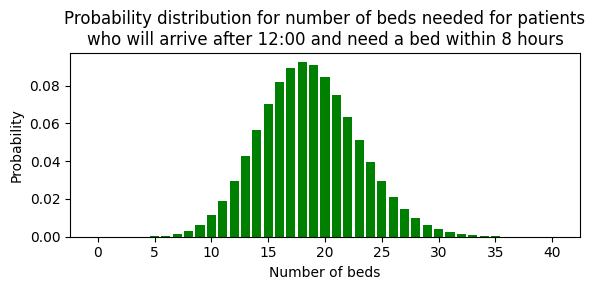

In [30]:
title = (
    f'Probability distribution for number of beds needed for patients\n'
    f'who will arrive after {format_prediction_time(prediction_time)} '
    f'and need a bed within 8 hours'
)
plot_prob_dist(yta_distribution, title, include_titles=True, truncate_at_beds=40, bar_colour='green')

Because this distribution is based on a Poisson model, the `DemandPredictor` can regenerate it from just the Poisson mean (lambda). The model provides a `predict_mean()` method for this purpose. This is what `build_service_data()` uses internally in the 4x_ notebooks — it stores just the Poisson rate in the `FlowInputs` container, and the `DemandPredictor` reconstructs the full distribution when needed.

In [31]:
# predict_mean() returns just the Poisson rate (a single float)
yta_lambda = yta_model.predict_mean(prediction_context, x1=x1, y1=y1, x2=x2, y2=y2)

print(f'Yet-to-arrive Poisson rate (lambda): {yta_lambda:.3f}')


Yet-to-arrive Poisson rate (lambda): 18.618


We can wrap this Poisson rate in a `FlowInputs` container. The key difference from Step 2 is that `flow_type` is `"poisson"` and `distribution` is a float (the rate) rather than a numpy array.

In [32]:
ed_yta_flow = FlowInputs(
    flow_id="ed_yta",
    flow_type="poisson",
    distribution=yta_lambda,
    display_name="ED yet-to-arrive admissions"
)

print(f'Flow ID:       {ed_yta_flow.flow_id}')
print(f'Flow type:     {ed_yta_flow.flow_type}')
print(f'Display name:  {ed_yta_flow.get_display_name()}')
print(f'Distribution:  {ed_yta_flow.distribution} (Poisson lambda)')


Flow ID:       ed_yta
Flow type:     poisson
Display name:  ED yet-to-arrive admissions
Distribution:  18.618075334578297 (Poisson lambda)


Both PMF and Poisson flows use the same `FlowInputs` container, distinguished only by `flow_type`. This uniform interface means downstream code can handle any flow without special-casing.

## Step 4: Group flows into a `ServicePredictionInputs`

A hospital service (e.g. "medical") has multiple sources of incoming patients and potentially outgoing patients too. `ServicePredictionInputs` groups all of these into a single object, organised as **inflows** and **outflows**.

Let's build one using the two flows we just created. For the departure flows, we'll create simple fake PMFs from a Poisson distribution to represent expected discharges. For transfers and other inflows where we don't have models, we use zero placeholders — a PMF of `[1.0]` (certainly zero patients) or a Poisson rate of `0.0`.

In [33]:
from patientflow.predict.service import ServicePredictionInputs
from scipy.stats import poisson as poisson_dist

prediction_window = timedelta(hours=8)

# Create fake departure PMFs from Poisson distributions
emergency_departure_pmf = poisson_dist.pmf(np.arange(30), mu=5)  # ~5 emergency discharges expected
elective_departure_pmf = poisson_dist.pmf(np.arange(20), mu=2)   # ~2 elective discharges expected

service_inputs = ServicePredictionInputs(
    service_id='medical',
    prediction_window=prediction_window,
    inflows={
        'ed_current': ed_current_flow,
        'ed_yta': ed_yta_flow,
        'non_ed_yta': FlowInputs(
            flow_id='non_ed_yta', flow_type='poisson',
            distribution=0.0, display_name='Non-ED emergency admissions',
        ),
        'elective_yta': FlowInputs(
            flow_id='elective_yta', flow_type='poisson',
            distribution=0.0, display_name='Elective admissions',
        ),
        'elective_transfers': FlowInputs(
            flow_id='elective_transfers', flow_type='pmf',
            distribution=np.array([1.0]),
            display_name='Elective transfers from other services',
        ),
        'emergency_transfers': FlowInputs(
            flow_id='emergency_transfers', flow_type='pmf',
            distribution=np.array([1.0]),
            display_name='Emergency transfers from other services',
        ),
    },
    outflows={
        'emergency_departures': FlowInputs(
            flow_id='emergency_departures', flow_type='pmf',
            distribution=emergency_departure_pmf,
            display_name='Emergency inpatient departures',
        ),
        'elective_departures': FlowInputs(
            flow_id='elective_departures', flow_type='pmf',
            distribution=elective_departure_pmf,
            display_name='Elective inpatient departures',
        ),
    },
)

print(service_inputs)

ServicePredictionInputs(service='medical')
  INFLOWS:
    Admissions from current ED               PMF[2:12]: [0.007, 0.026, 0.071, 0.135, 0.191, 0.204, 0.169, 0.109, 0.056, 0.022] (E=6.9 of 21 patients in ED)
    ED yet-to-arrive admissions              λ = 18.618
    Non-ED emergency admissions              λ = 0.000
    Elective admissions                      λ = 0.000
    Elective transfers from other services   PMF[0:1]: [1.000] (E=0.0)
    Emergency transfers from other services  PMF[0:1]: [1.000] (E=0.0)
  OUTFLOWS:
    Emergency inpatient departures           PMF[0:10]: [0.007, 0.034, 0.084, 0.140, 0.175, 0.175, 0.146, 0.104, 0.065, 0.036] (E=5.0 of 29 emergency patients in service)
    Elective inpatient departures            PMF[0:10]: [0.135, 0.271, 0.271, 0.180, 0.090, 0.036, 0.012, 0.003, 0.001, 0.000] (E=2.0 of 19 elective patients in service)


The printed representation shows all inflows and outflows at a glance. The `ed_current` flow shows the PMF from Step 1, and the `ed_yta` flow shows the Poisson rate from Step 3. The departure flows use fake Poisson PMFs (with expected values of ~5 and ~2 respectively), and the transfer flows are zero placeholders.

In a production system, these departure distributions would come from discharge prediction models, and the transfer flows would also be populated. You'll see this in the 4x_ notebooks.

## Step 5: Use `DemandPredictor` to generate a prediction

The `DemandPredictor` takes a `ServicePredictionInputs` and convolves the selected flows into a combined probability distribution. This is the same convolution we performed manually in notebook 3e (where we convolved multiple Poisson distributions using `np.convolve`), but wrapped in a method that handles both PMF and Poisson flows automatically.

Let's predict demand using only the current ED patients first.

In [34]:
from patientflow.predict.demand import DemandPredictor
from patientflow.predict.demand import FlowSelection

predictor = DemandPredictor(k_sigma=8.0)

# Predict using only the current ED patients
current_ed_bundle = predictor.predict_service(
    inputs=service_inputs,
    flow_selection=FlowSelection.custom(
        include_ed_current=True,
        include_ed_yta=False,
        include_non_ed_yta=False,
        include_elective_yta=False,
        include_transfers_in=False,
        include_departures=False,
        cohort='emergency'
    )
)

The result is a `PredictionBundle` containing a `DemandPrediction` for arrivals. Let's look at the arrivals prediction — this corresponds to the PMF we started with.

In [35]:
arrivals = current_ed_bundle.arrivals

print(f'Expectation:          {arrivals.expectation:.1f}')
print(f'Expected value:       {arrivals.mode}')
print(f'Percentiles:          {arrivals.percentiles}')
print(f'PMF shape:            {arrivals.probabilities.shape}')

Expectation:          6.9
Expected value:       7
Percentiles:          {25: 6, 50: 7, 75: 8}
PMF shape:            (22,)


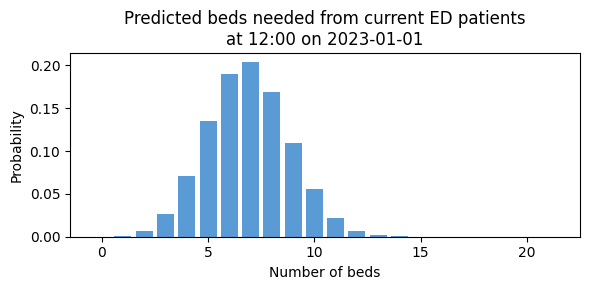

In [36]:
title = (
    f'Predicted beds needed from current ED patients\n'
    f'at {format_prediction_time(prediction_time)} '
    f'on {snapshot_date}'
)
plot_prob_dist(arrivals.probabilities, title, include_titles=True)

This is the same distribution as Step 1 — the `DemandPredictor` simply passes through the PMF when there is only one flow selected. The value is in what it provides: summary statistics (expectation, mode, percentiles) and the ability to combine multiple flows, as we'll see next.

## Step 6: Use `FlowSelection` to control which flows are included

The `FlowSelection` class is a toggle for which flows to include in a prediction. It provides several presets and a `custom()` method for full control.

Let's combine current ED patients with yet-to-arrive patients. This is where convolution happens — the `DemandPredictor` convolves the PMF from current patients with the Poisson distribution from yet-to-arrive patients to produce a single combined distribution.

In [37]:
# Include both current ED and yet-to-arrive patients
combined_bundle = predictor.predict_service(
    inputs=service_inputs,
    flow_selection=FlowSelection.custom(
        include_ed_current=True,
        include_ed_yta=True,
        include_non_ed_yta=False,
        include_elective_yta=False,
        include_transfers_in=False,
        include_departures=False,
        cohort='emergency'
    )
)

print(f'Current ED only — expected beds: {current_ed_bundle.arrivals.expectation:.1f}')
print(f'Yet-to-arrive only — Poisson rate: {yta_lambda:.1f}')
print(f'Combined — expected beds: {combined_bundle.arrivals.expectation:.1f}')


Current ED only — expected beds: 6.9
Yet-to-arrive only — Poisson rate: 18.6
Combined — expected beds: 25.5


The expected value of the combined distribution equals the sum of the individual expected values — a property of convolution. But the full probability distribution captures the combined uncertainty, not just the means.

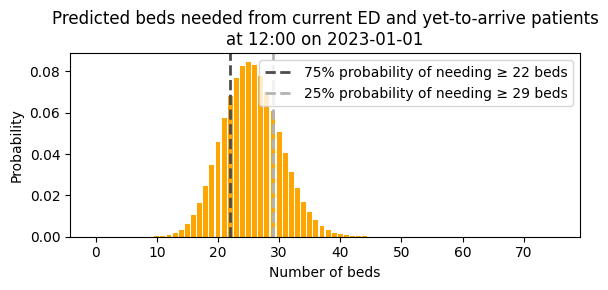

In [38]:
title = (
    f'Predicted beds needed from current ED and yet-to-arrive patients\n'
    f'at {format_prediction_time(prediction_time)} '
    f'on {snapshot_date}'
)
plot_prob_dist(
    combined_bundle.arrivals.probabilities, title,
    include_titles=True,
    probability_levels=[0.75, 0.25],
    show_probability_thresholds=True,
    bar_colour='orange'
)

Now let's compare two presets — `FlowSelection.incoming_only()` includes all inflows but no departures, while `FlowSelection.default()` includes everything.

In [39]:
incoming_bundle = predictor.predict_service(
    inputs=service_inputs,
    flow_selection=FlowSelection.incoming_only()
)

default_bundle = predictor.predict_service(
    inputs=service_inputs,
    flow_selection=FlowSelection.default()
)

print('=== FlowSelection.incoming_only() ===')
print(f'  Expected arrivals:   {incoming_bundle.arrivals.expectation:.1f}')
print(f'  Expected departures: {incoming_bundle.departures.expectation:.1f}')
print(f'  Expected net flow:   {incoming_bundle.net_flow.expectation:.1f}')
print()
print('=== FlowSelection.default() ===')
print(f'  Expected arrivals:   {default_bundle.arrivals.expectation:.1f}')
print(f'  Expected departures: {default_bundle.departures.expectation:.1f}')
print(f'  Expected net flow:   {default_bundle.net_flow.expectation:.1f}')

=== FlowSelection.incoming_only() ===
  Expected arrivals:   25.5
  Expected departures: 0.0
  Expected net flow:   25.5

=== FlowSelection.default() ===
  Expected arrivals:   25.5
  Expected departures: 7.0
  Expected net flow:   18.5


The available presets are:
- `FlowSelection.default()` — all flows
- `FlowSelection.incoming_only()` — all inflows, no departures
- `FlowSelection.outgoing_only()` — only departures
- `FlowSelection.emergency_only()` — only emergency-related flows
- `FlowSelection.elective_only()` — only elective-related flows
- `FlowSelection.custom(...)` — full control over individual flow families

## Step 7: The `PredictionBundle` — arrivals, departures, and net flow

Every call to `predictor.predict_service()` returns a `PredictionBundle`. This bundles together three `DemandPrediction` objects:

- **arrivals** — the combined inflow distribution
- **departures** — the combined outflow distribution
- **net_flow** — the difference (arrivals minus departures)

It also records which `FlowSelection` was used, so you can always trace what went into the prediction.

In [40]:
print(combined_bundle)

PredictionBundle(service: medical)
  Arrivals:    PMF[20:30]: [0.046, 0.057, 0.068, 0.077, 0.082, 0.085, 0.083, 0.078, 0.070, 0.061] (E=25.5)
  Departures:  PMF[0:1]: [1.000] (E=0.0)
  Net flow:    PMF[20:30]: [0.046, 0.057, 0.068, 0.077, 0.082, 0.085, 0.083, 0.078, 0.070, 0.061] (E=25.5)
  Flows:       selection cohort=emergency inflows(ed_current=True, ed_yta=True, non_ed_yta=False, elective_yta=False, transfers_in=False) outflows(departures=False)


Each `DemandPrediction` carries useful summary statistics:

In [41]:
arrivals = combined_bundle.arrivals

print(f'Expected beds:       {arrivals.expectation:.1f}')
print(f'Most likely (mode):  {arrivals.mode}')
print(f'Percentiles:         {arrivals.percentiles}')
print(f'90% probability:     need at least {arrivals.min_beds_with_probability(0.9)} beds')
print(f'PMF array length:    {len(arrivals.probabilities)}')

Expected beds:       25.5
Most likely (mode):  25
Percentiles:         {25: 22, 50: 25, 75: 29}
90% probability:     need at least 20 beds
PMF array length:    76


The `flow_selection` attribute records which flows were included:

In [42]:
fs = combined_bundle.flow_selection
print(f'ED current:       {fs.include_ed_current}')
print(f'ED yet-to-arrive: {fs.include_ed_yta}')
print(f'Non-ED YTA:       {fs.include_non_ed_yta}')
print(f'Elective YTA:     {fs.include_elective_yta}')
print(f'Transfers in:     {fs.include_transfers_in}')
print(f'Departures:       {fs.include_departures}')
print(f'Cohort:           {fs.cohort}')

ED current:       True
ED yet-to-arrive: True
Non-ED YTA:       False
Elective YTA:     False
Transfers in:     False
Departures:       False
Cohort:           emergency


## Summary

In this notebook we traced the path from familiar 3x_ outputs to the structured data classes used in the 4x_ notebooks:

| 3x_ concept | 4x_ equivalent | What changed? |
|---|---|---|
| Raw PMF array from `get_prob_dist_for_prediction_moment()` | `FlowInputs(flow_type="pmf", distribution=pmf_array)` | Same numbers, named container |
| Poisson distribution from yet-to-arrive model | `FlowInputs(flow_type="poisson", distribution=lambda)` | Rate stored; full distribution regenerated when needed |
| Manual `np.convolve()` of multiple distributions | `DemandPredictor.predict_service()` | Same maths, handled automatically |
| Ad-hoc selection of which inputs to include | `FlowSelection.incoming_only()`, `.default()`, `.custom(...)` | Explicit, reproducible toggle |
| Individual result arrays | `PredictionBundle` with arrivals, departures, net flow | Structured output with summary statistics |

In notebook 4c, you'll see how `build_service_data()` constructs all of these automatically from trained models for the full UCLH implementation — building a dictionary of `ServicePredictionInputs` for every specialty in a single call.